In [1]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


In [2]:
import time
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim.models import Word2Vec
from konlpy.tag import Mecab
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns

## STEP 1. 형태소 분석기 이용해서 명사 추출

In [3]:
# Mecab 형태소 분석기 생성
mecab = Mecab()

# 텍스트 파일을 읽고 Mecab으로 토큰화하는 함수
def read_txt(file_name):
    data = []
    start = time.time()
    
    with open(f'./data/{file_name}', 'r') as file:
        while True:
            line = file.readline().strip()
            if not line: 
                break
            line = re.sub("[ ]+", " ", line)
            
            # Mecab으로 토큰화
            words = mecab.morphs(line)
            words = [word for word in words if len(word) != 1]  # 한 글자 단어는 제외
            data += [words]
    
    end = time.time()
    print(f"{file_name} 처리 시간: {end - start}")
    return data

## STEP 2. 추출된 명사로 Embedding model

In [4]:
# 장르별 텍스트 파일 목록
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
# 각 장르에 해당하는 장르명
genre_name = ['예술', '일반', 'SF', '가족', '공연', '공포', '기타', '다큐멘터리', '드라마', '로맨스', '뮤지컬', '미스터리', '범죄', '역사', '서부극',
         '성인', '스릴러', '애니메이션', '액션', '모험', '전쟁', '코미디', '판타지']

- 공포(호러)가 없음..

In [5]:
# 전체 데이터 불러오기
data = []
for txt in genre_txt:
    data += read_txt(txt)
    
model = Word2Vec(data, vector_size=100, window=5, min_count=3, sg=1)  

synopsis_SF.txt 처리 시간: 0.28876566886901855
synopsis_family.txt 처리 시간: 0.12355184555053711
synopsis_show.txt 처리 시간: 0.10302734375
synopsis_horror.txt 처리 시간: 0.7887680530548096
synopsis_etc.txt 처리 시간: 0.6492016315460205
synopsis_documentary.txt 처리 시간: 2.0627357959747314
synopsis_drama.txt 처리 시간: 5.163269281387329
synopsis_romance.txt 처리 시간: 1.3819384574890137
synopsis_musical.txt 처리 시간: 0.0551295280456543
synopsis_mystery.txt 처리 시간: 0.22190594673156738
synopsis_crime.txt 처리 시간: 0.3773305416107178
synopsis_historical.txt 처리 시간: 0.045919179916381836
synopsis_western.txt 처리 시간: 0.012176036834716797
synopsis_adult.txt 처리 시간: 0.6783888339996338
synopsis_thriller.txt 처리 시간: 0.5833554267883301
synopsis_animation.txt 처리 시간: 1.670705795288086
synopsis_action.txt 처리 시간: 1.5342645645141602
synopsis_adventure.txt 처리 시간: 0.25283288955688477
synopsis_war.txt 처리 시간: 0.11302995681762695
synopsis_comedy.txt 처리 시간: 1.4462647438049316
synopsis_fantasy.txt 처리 시간: 0.15834617614746094


## STEP 3. target, attribute 단어 셋 만들기

In [6]:
# 대표 단어 선정 : 유사도 높은 상위 10개
def similar_word_arr(model, genre_name):
    similar_words = model.wv.most_similar(positive=[genre_name])  # genre_name과 유사한 단어들을 상위 10개까지 가져옴
    similar_words = list(map(lambda x: x[0], similar_words))
    similar_arr = [model.wv[word] for word in similar_words]
    return similar_words, similar_arr

## STEP 4. 장르별 WEAT 계산하기

In [7]:
# 코사인 유사도
def cos_sim(i, j):
    return np.dot(i, j.T)/(np.linalg.norm(i)*np.linalg.norm(j))

In [8]:
# 하나의 타겟 단어와 여러개의 attribute 단어들
def s(w, a, b):
    similar_tar_attr_01 = []
    for attr in a:
        similar_tar_attr_01 += [cos_sim(w[1], attr[1])]

    mean_similar_01 = np.mean(similar_tar_attr_01)

    similar_tar_attr_02 = []
    for attr in b:
        similar_tar_attr_02 += [cos_sim(w[1], attr[1])]

    mean_similar_02 = np.mean(similar_tar_attr_02)
    
    return mean_similar_01 - mean_similar_02

In [9]:
def weat_score(w1, w2, a, b):
    mean_s_01 = []
    for w in w1:
        mean_s_01 += [s(w, a, b)]
    mean01 = np.mean(mean_s_01)
    
    mean_s_02 = []
    for w in w2:
        mean_s_02 += [s(w, a, b)]
    mean02 = np.mean(mean_s_02)
    
    std = np.std(np.concatenate([mean_s_01, mean_s_02]))
    
    return (mean01 - mean02) / std

In [10]:
result = defaultdict()

for genre in genre_name:
    result[genre] = similar_word_arr(model, genre)   

In [11]:
target_word_01, target_arr_01 = result[genre_name[0]]
target_word_02, target_arr_02 = result[genre_name[1]]


art_bias = []
normal_bias = []
nothing_bias = []

for i in range(2, len(result)):
    attr_word_01, attr_arr_01 = result[genre_name[i]]
    for j in range(i + 1, len(result)):
        attr_word_02, attr_arr_02 = result[genre_name[j]]
        
        weat = weat_score(target_arr_01, target_arr_02, attr_arr_01, attr_arr_02)
        if weat > 0.05:
            print(f"\"{genre_name[0]}\"는 \"{genre_name[i]}\"에 편향되어 있습니다. {weat}")
            art_bias += [genre_name[i]]
            print(f"\"{genre_name[1]}\"는 \"{genre_name[j]}\"에 편향되어 있습니다. {weat}")
            normal_bias += [genre_name[j]]
        elif weat < -0.05:
            print(f"\"{genre_name[0]}\" 장르는 \"{genre_name[j]}\" 장르에 편향되어 있습니다. {weat}")
            art_bias += [genre_name[j]]
            print(f"\"{genre_name[1]}\" 장르는 \"{genre_name[i]}\" 장르에 편향되어 있습니다. {weat}")
            normal_bias += [genre_name[i]]
        elif weat >= -0.05 and weat <= 0.05:
            print(f"\"{genre_name[0]}\" 장르는 편향되지 않은 장르입니다. {weat}")        
            nothing_bias += [genre_name[j]]

"예술" 장르는 "가족" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "공연" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "공포" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "기타" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "다큐멘터리" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "드라마" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "로맨스" 장르에 편향되어 있습니다. -1.1547003984451294
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.1547003984451294
"예술" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -1.1547006368637085
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.1547006368637085
"예술" 장르는 "미스터리" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "범죄" 장르에 편향되어 있습니다. -1.1547006368637085
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.1547006368637085
"예술" 장르는 "역사" 장르에 편향되어 있습니

/tmp/ipykernel_1152/3546691080.py:14: RuntimeWarning: invalid value encountered in float_scalars
  return (mean01 - mean02) / std


"예술" 장르는 "코미디" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "판타지" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "SF" 장르에 편향되어 있습니다. -1.154700517654419
"예술"는 "가족"에 편향되어 있습니다. 1.154700517654419
"일반"는 "공연"에 편향되어 있습니다. 1.154700517654419
"예술"는 "가족"에 편향되어 있습니다. 1.1547006368637085
"일반"는 "기타"에 편향되어 있습니다. 1.1547006368637085
"예술"는 "가족"에 편향되어 있습니다. 1.154700517654419
"일반"는 "다큐멘터리"에 편향되어 있습니다. 1.154700517654419
"예술"는 "가족"에 편향되어 있습니다. 1.154700517654419
"일반"는 "드라마"에 편향되어 있습니다. 1.154700517654419
"예술" 장르는 "로맨스" 장르에 편향되어 있습니다. -1.1547006368637085
"일반" 장르는 "가족" 장르에 편향되어 있습니다. -1.1547006368637085
"예술"는 "가족"에 편향되어 있습니다. 1.1547003984451294
"일반"는 "뮤지컬"에 편향되어 있습니다. 1.1547003984451294
"예술"는 "가족"에 편향되어 있습니다. 1.1547006368637085
"일반"는 "미스터리"에 편향되어 있습니다. 1.1547006368637085
"예술"는 "가족"에 편향되어 있습니다. 1.1547003984451294
"일반"는 "범죄"에 편향되어 있습니다. 1.1547003984451294
"예술"는 "가족"에 편향되어 있습니다. 1.154700517654419
"일반"는 "역사"에 편향되어 있습니다. 1.154700517654419
"예술"는 "가족"에 편향되어 있습니다. 1.15470051765

"예술" 장르는 "역사" 장르에 편향되어 있습니다. -1.1547006368637085
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -1.1547006368637085
"예술" 장르는 "서부극" 장르에 편향되어 있습니다. -1.1547006368637085
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -1.1547006368637085
"예술" 장르는 "성인" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "스릴러" 장르에 편향되어 있습니다. -1.1547006368637085
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -1.1547006368637085
"예술" 장르는 "애니메이션" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "액션" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "모험" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -1.154700517654419
"예술"는 "뮤지컬"에 편향되어 있습니다. 1.1547006368637085
"일반"는 "전쟁"에 편향되어 있습니다. 1.1547006368637085
"예술" 장르는 "코미디" 장르에 편향되어 있습니다. -1.154700517654419
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -1.154700517654419
"예술" 장르는 "판타지" 장르에 편향되어 있습니다. -1.1547003984451294
"일반" 장르는 "뮤지컬" 장르에 편향되어 있습니다. -1.1547003984451294
"예술"는 "미스터리"에 편향되어 있습니다. 1.

In [12]:
len(genre_name)

23

In [13]:
# 예술 분야에 편향된 장르
set(art_bias) - set(normal_bias)

{'로맨스'}

In [14]:
# 일반 분야에 편향된 장르
set(normal_bias) - set(art_bias) 

{'SF', '전쟁'}

In [15]:
nothing_bias

[]

## STEP 5. 예술, 일반장르 편향성 및 시각화

- venn  https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram

In [16]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

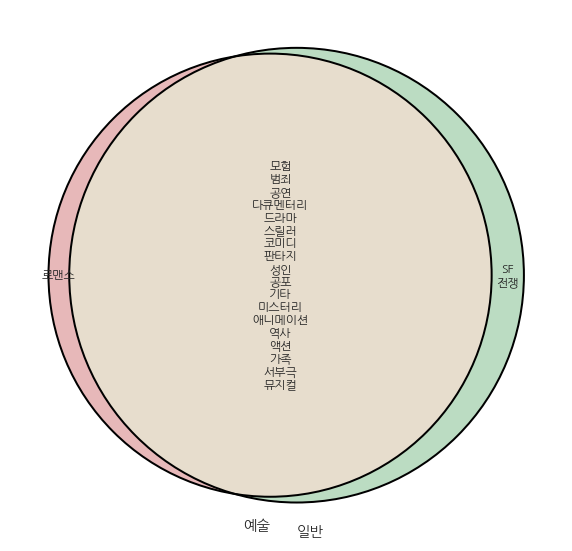

In [17]:
import matplotlib.pyplot as plt 
from matplotlib_venn import venn2, venn2_circles

plt.figure(figsize = (10, 10))
A = set(art_bias) 
B = set(normal_bias) 
v = venn2(subsets=[A, B], set_labels=('예술', '일반')) 
venn2_circles(subsets=[A, B], linestyle='solid')

v.get_label_by_id('100').set_text('\n'.join(map(str,A-B)))
v.get_label_by_id('110').set_text('\n'.join(map(str,A&B)))
v.get_label_by_id('010').set_text('\n'.join(map(str,B-A)))

plt.show()

## 회고
- 프로젝트 중반 쯤에 확인하는 용으로는 좋은 것 같습니다.
- 사실 인공지능이 인간적인 면을 보일 수 있는 부분이 편향이라고 생각이 들긴 하지만, 편향성 측정의 의도를 아직 잘 모르겠습니다.
- 결과를 보면서, 이런 부분이 내가 의도한 부분일까, 아니면 내 상식 선의 편향인가? 라는 생각이 듭니다!